In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf:
    print(module.__name__, module.__version__)

2.13.0
sys.version_info(major=3, minor=10, micro=6, releaselevel='final', serial=0)
matplotlib 3.7.2
numpy 1.24.3
pandas 2.0.3
sklearn 1.3.0
tensorflow 2.13.0


In [17]:
# fashion_mnist图像分类数据集   60000个样本，每个样本28*28的特征  target 0-9 对应不同衣服种类
fashion_mnist = keras.datasets.fashion_mnist
# 数据加载本地用户.keras文件中
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# 验证集、训练集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_train.shape[:1])

(55000,) (55000,)


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  44 127 182 185 161 120  55
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  42 198 251 255 251 249 247 255 252
  214 100   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0 233 252 237 239 234 237 235 237 237
  254 227   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   2   0   0  16 210 225 215 175 217 216 193 196 226
  221 209  50   0   0   2   0   0   0   0]
 [  0   0   0   0   2   0   0 199 229 232 230 245 204 219 253 245 207 194
  223 231 236 235   0   0   3   0   0   0]
 [  0   0   0   0   1   0 137 235 204 209 201 209 234 190 234 218 215 238
  239 204 189 224 154   0   0   0   0   0]
 [  0   0   0   0   0   0 194 201 200 209 202 193 205 194 183 218 231 197
  172 181 193 205 199   0   0   0   0   0]
 [  0   0   0   0   0   3 212 203 188 189 196 198 198 201 196 21

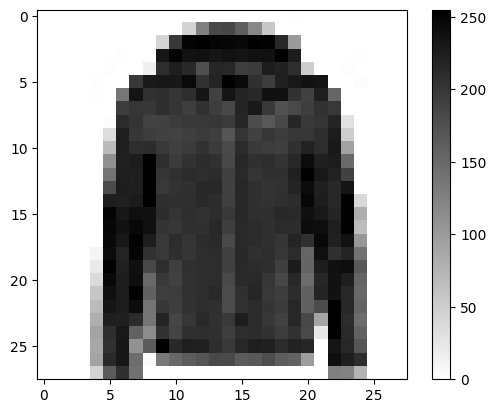

227
0


In [18]:
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap='binary')
    plt.colorbar()
    plt.show()


print(x_train[0])
show_single_image(x_train[0])
print(x_train[0, 3, 19])
print(y_train[1])

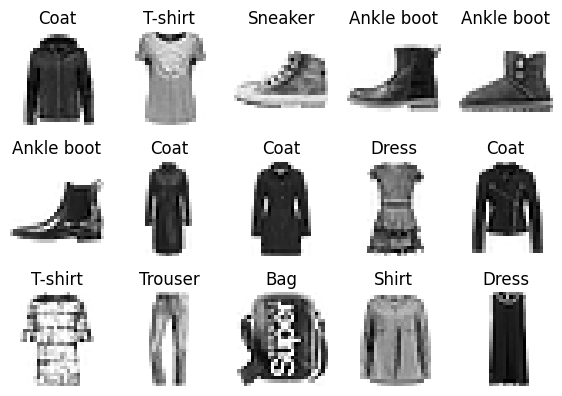

In [23]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)      # 确保打印图片小于总数
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            # cmap 颜色映射方法     interpolation 图片的平滑程度  邻近补偿
            plt.imshow(x_data[index], cmap='binary', interpolation='nearest')
            plt.axis('off')  # 去除坐标系
            plt.title(class_names[y_data[index]])
    plt.show()


class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)


In [24]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28,28]))
print(model.output_shape)
#Dense是全连接层，添加全连接层，单元数是300，可以对比300和100的差异
# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3],
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3
model.add(keras.layers.Dense(300,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(30,activation='softmax'))

# reason for sparse: y->index. y->one_hot->[]
#loss是损失函数 y如果只是一个数，那么使用sparse_categorical_crossentropy
#sparse_categorical_crossentropy计算稀疏分类crossentropy损失。
# 计算的分类值是 0,1,2,...9
# 如果是一个向量，那么使用categorical_crossentropy，详情看课件
#optimizer是优化方法
# metrics模型在训练和测试期间要评估的指标列表
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= keras.optimizers.SGD(0.001),
              metrics=['accuracy'])

(None, 784)


In [25]:
model.layers

In [27]:
model.summary()   #打印model每层输出、参数总和（输入+输出）

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 30)                3030      
                                                                 
Total params: 268630 (1.02 MB)
Trainable params: 268630 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.variables  #模型中自己训练的参数
# 参数服从glorot_uniform均匀分布[-limit,limit]
# limit = np.sqrt(6/in+out)

[<tf.Variable 'dense/kernel:0' shape=(784, 300) dtype=float32, numpy=
 array([[-0.07055084,  0.02783252, -0.02892874, ...,  0.0035194 ,
          0.01291794,  0.03981925],
        [ 0.06167665,  0.03127952,  0.05989616, ..., -0.07279908,
         -0.03229127, -0.02617323],
        [ 0.0112398 , -0.04320689, -0.01053357, ..., -0.01798315,
         -0.0336623 ,  0.02825914],
        ...,
        [-0.01315781, -0.00815859, -0.03431537, ..., -0.03368019,
         -0.04561207, -0.00683537],
        [ 0.00782318,  0.03340561, -0.01042026, ...,  0.05489159,
         -0.07234992, -0.06793318],
        [-0.03914116, -0.00448298,  0.04337157, ...,  0.01218463,
          0.07325041,  0.03201945]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(300,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [30]:
# [None, 784] * W + b -> [None, 300]
# W.shape [784, 300], b = [300]
#W是矩阵，b是一个偏置，是一个向量

In [31]:

history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 12s 7ms/step - loss: 2.7745 - accuracy: 0.7328 - val_loss: 0.5836 - val_accuracy: 0.8066
Epoch 2/20
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5392 - accuracy: 0.8075 - val_loss: 0.5306 - val_accuracy: 0.8158
Epoch 3/20
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4808 - accuracy: 0.8255 - val_loss: 0.5083 - val_accuracy: 0.8348
Epoch 4/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4465 - accuracy: 0.8366 - val_loss: 0.4925 - val_accuracy: 0.8382
Epoch 5/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4237 - accuracy: 0.8443 - val_loss: 0.4582 - val_accuracy: 0.8468
Epoch 6/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4060 - accuracy: 0.8502 - val_loss: 0.4504 - val_accuracy: 0.8464
Epoch 7/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3910 - accuracy: 0.8551 - val_loss: 0.4477 - val_ac

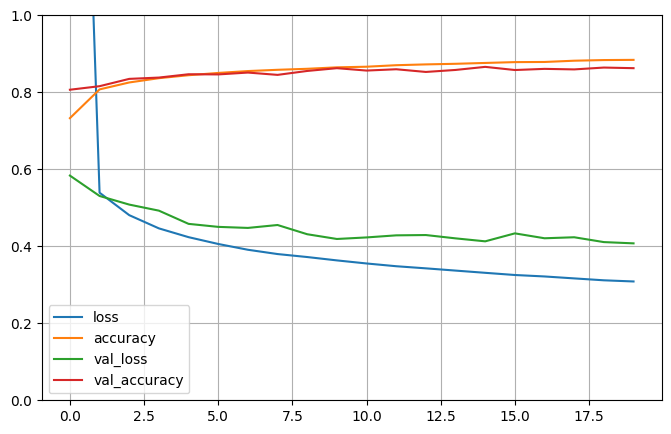

In [36]:
# history曲线
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [39]:
model.evaluate(x_test,y_test,verbose=0)

[0.452606737613678, 0.8517000079154968]

In [40]:
#计算标签和预测之间的crossentropy(交叉熵)损失
cce = keras.losses.SparseCategoricalCrossentropy()
loss = cce(
  [0, 1, 2],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
print('Loss: ', loss.numpy())

Loss:  0.09458992
